In [1]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### grab data

In [2]:
league_id = 123456
year = 2018
swid = 'your swid'
espn = 'your espn_s2'
url = "https://fantasy.espn.com/apis/v3/games/ffl/leagueHistory/" + \
      str(league_id) + "?seasonId=" + str(year)

r = requests.get(url,
                 params={"view": "mMatchup"},
                 cookies={"SWID": swid, "espn_s2": espn})
# d = r.json()
d = r.json()[0]

### clean it up

In [3]:
df = [[
        game['matchupPeriodId'],
        game['home']['teamId'], game['home']['totalPoints'],
        game['away']['teamId'], game['away']['totalPoints']
    ] for game in d['schedule']]
df = pd.DataFrame(df, columns=['Week', 'Team1', 'Score1', 'Team2', 'Score2'])
df['Type'] = ['Regular' if w<=14 else 'Playoff' for w in df['Week']]
df.head()

,Week,Team1,Score1,Team2,Score2,Type
0,1,5,84.0,12,91.0,Regular
1,1,13,123.0,1,109.0,Regular
2,1,15,130.0,9,140.0,Regular
3,1,2,128.0,14,139.0,Regular
4,1,3,98.0,4,131.0,Regular


### compute average score per week

In [4]:
# get average score per week
avgs = (df
 .filter(['Week', 'Score1', 'Score2'])
 .melt(id_vars=['Week'], value_name='Score')
 .groupby('Week')
 .mean()
 .reset_index()
)
avgs.head()

,Week,Score
0,1,117.3
1,2,103.1
2,3,116.2
3,4,116.1
4,5,113.6


### plot

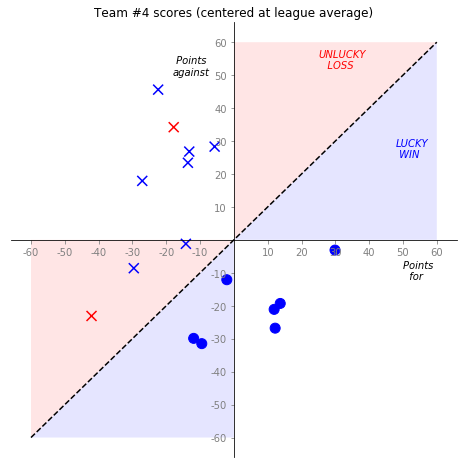

In [5]:
tm = 4

# grab all games with this team
df2 = df.query('Team1 == @tm | Team2 == @tm').reset_index(drop=True)

# move the team of interest to "Team1" column
ix = list(df2['Team2'] == tm)
df2.loc[ix, ['Team1','Score1','Team2','Score2']] = \
    df2.loc[ix, ['Team2','Score2','Team1','Score1']].values

# add new score and win cols
df2 = (df2
 .assign(Chg1 = df2['Score1'] - avgs['Score'],
         Chg2 = df2['Score2'] - avgs['Score'],
         Win  = df2['Score1'] > df2['Score2'])
)


# VISUALIZATION

fig, ax = plt.subplots(1,1, figsize=(8,8))

z = 60

ax.fill_between([0,z], 0, [0,z], facecolor='b', alpha=0.1)
ax.fill_between([-z,0], -z, [-z,0], facecolor='b', alpha=0.1)
ax.fill_between([0,z], [0,z], z, facecolor='r', alpha=0.1)
ax.fill_between([-z,0], [-z,0], 0, facecolor='r', alpha=0.1)

ax.scatter(data=df2.query('Win'), x='Chg1', y='Chg2', 
           c=['b' if t=='Regular' else 'r' for t in df2.query('Win')['Type']], 
           s=100,
           marker='o',
           label='Win')
ax.scatter(data=df2.query('not Win'), x='Chg1', y='Chg2', 
           c=['b' if t=='Regular' else 'r' for t in df2.query('not Win')['Type']], 
           s=100,
           marker='x',
           label='Loss')
ax.plot([-z,z],[-z,z], 'k--')

# ax.legend()

# center x/y axes on origin
ax.spines['left'].set_position('zero')
ax.spines['right'].set_color('none')
ax.spines['bottom'].set_position('zero')
ax.spines['top'].set_color('none')
ax.yaxis.tick_left()
ax.xaxis.tick_bottom()

# remove origin ticklabels
tx = list(range(-z,z+1,10))
tx.remove(0)
ax.yaxis.set(ticks=tx, ticklabels=tx)
ax.xaxis.set(ticks=tx, ticklabels=tx)

ax.tick_params(axis='x', colors='gray')
ax.tick_params(axis='y', colors='gray')

ax.text(z-10, -12, 'Points \n  for', style='italic')
ax.text(-18, z-10, ' Points \nagainst', style='italic')
ax.text(z/2-5, z-8, 'UNLUCKY\n   LOSS', style='italic', color='red')
ax.text(z-12, z/2-5, 'LUCKY\n WIN', style='italic', color='blue')

ax.set(title='Team #%d scores (centered at league average)' % tm)

plt.show()